# Classification with ML algorithms
This notebook walks through the steps I took to classify the corpus, including:

1) Data preparation and manual classification of the sample.
2) Training and comparing various machine learning models to identify the best-performing classifier.

In [1]:
# General purpose libraries
import time  # For measuring execution time
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis

In [2]:
# Text preprocessing and word cloud visualization
from nltk.corpus import stopwords  # To remove stop words from text data
from nltk.stem.snowball import SnowballStemmer  # For stemming (reducing words to root form)
snowballStemmer = SnowballStemmer("portuguese")  # Initialize Snowball Stemmer for Portuguese
from wordcloud import WordCloud  # To create word clouds
import matplotlib.pyplot as plt  # For data visualization

In [3]:
# Scikit-learn: Machine learning and model evaluation
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.pipeline import Pipeline  # To streamline preprocessing and modeling workflows
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.metrics import accuracy_score  # To evaluate model accuracy
from sklearn.preprocessing import LabelEncoder  # To encode labels into numeric values

In [4]:
# Scikit-learn: Classifiers
from sklearn import naive_bayes  # Naive Bayes classifier
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier

In [5]:
# TensorFlow/Keras: Deep learning models
from tensorflow.keras.models import Sequential  # For creating deep learning models
from tensorflow.keras.layers import Embedding, LSTM, Dense  # Layers for LSTM-based models
from tensorflow.keras.preprocessing.text import Tokenizer  # To tokenize text data
from tensorflow.keras.preprocessing.sequence import pad_sequences  # To pad sequences for uniform input length
import tensorflow as tf  # TensorFlow backend for Keras

In [6]:
# Load the pre-classified sample of manifestos into a DataFrame
# The 'Unnamed: 0' column is the default index column created during the previous export and is being set as the index here
df = pd.read_csv('sample_lines.csv', index_col='Unnamed: 0')

# Display information about the DataFrame to understand its structure and content
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24593 entries, 0 to 24592
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     24593 non-null  object
 1   id       24593 non-null  object
 2   section  24592 non-null  object
dtypes: object(3)
memory usage: 768.5+ KB
None


In [7]:
# First and last rows
print(df.head())

                                    text               id section
0  PLANO DE TRABALHO PARA LUZINÓPOLIS/TO  270,000,010,503  Titulo
1                         AÇÕES E METAS   270,000,010,503  Titulo
2                             COLIGAÇÃO   270,000,010,503  Titulo
3             “QUEM É DAQUI FAZ MELHOR”   270,000,010,503  Titulo
4                             CANDIDATO   270,000,010,503  Titulo


In [8]:
# First and last rows
print(df.tail())

                                                    text                id  \
24588    Atenção  prioritária  à  criança  e  ao  ad...  250,000,080,953    
24589  funcionamento  dos  Conselhos  Tutelar  e  Mun...  250,000,080,953    
24590  implantando  centros  de  educação  esporte  c...  250,000,080,953    
24591                             promovendo  palestras   250,000,080,953    
24592  educativas de combate às drogas e mantendo o N...  250,000,080,953    

               section  
24588  Politica Social  
24589  Politica Social  
24590  Politica Social  
24591  Politica Social  
24592  Politica Social  


In [9]:
# Verify if there are any null values
print("\nNull values in dataframe:")
print(df.isnull().sum())


Null values in dataframe:
text       0
id         0
section    1
dtype: int64


In [10]:
# Count number of words on each row
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [11]:
# Descriptive statistics for the word_count per line
df['word_count'].describe()

count    24593.000000
mean         7.605416
std          4.297478
min          0.000000
25%          4.000000
50%          8.000000
75%         11.000000
max         34.000000
Name: word_count, dtype: float64

In [12]:
pd.set_option('max_colwidth', 200)
df[df['word_count']==34]['text']

737    Assumimos também o resultado do plebiscito realizado nos dias 2 a 7 de setembro de 2002 quando 94% de um total de mais de seis milhões de eleitores sem campanhas na mídia e sem 
Name: text, dtype: object

### WordCloud

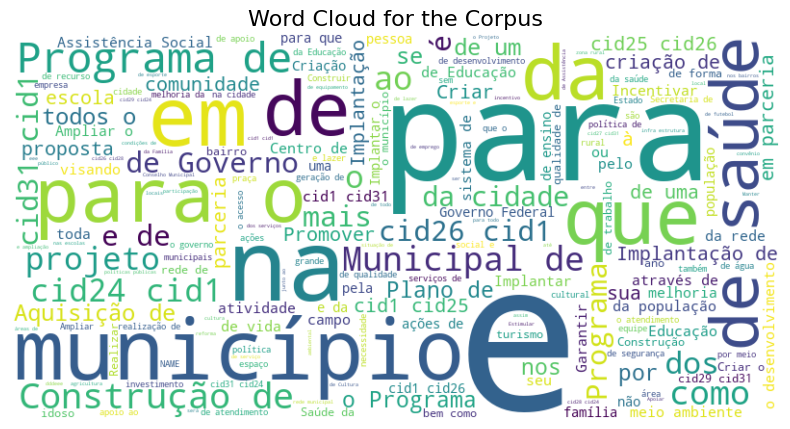

In [13]:
text=' '.join(df['text']) #creates a text for the corpus

# Generate a Word Cloud from the provided text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Create a figure to display the Word Cloud
plt.figure(figsize=(10, 5))  
plt.imshow(wordcloud, interpolation='bilinear')  # Display the Word Cloud with smooth interpolation
plt.axis('off')  # Turn off the axes to focus on the Word Cloud
plt.title('Word Cloud for the Corpus', fontsize=16)  
plt.show()  

It may be good to remove Stop Words and convert all the text to lower caps.

In [14]:
stop = stopwords.words("portuguese")

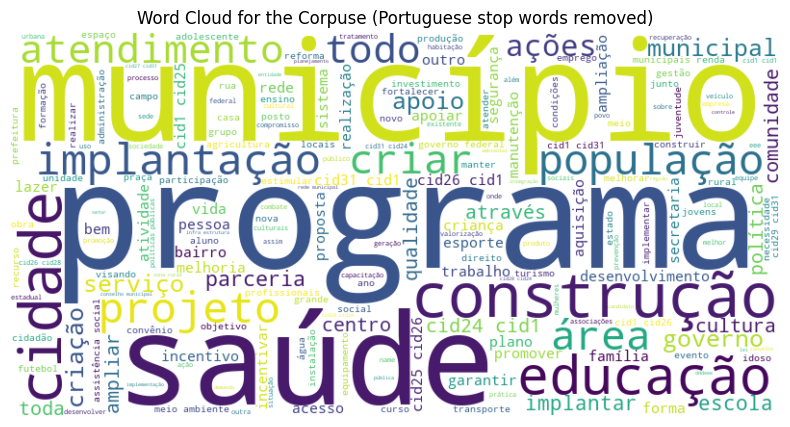

In [15]:
text_lower=' '.join([x.lower() for x in text.split()])
# Word Cloud para Reseñas Positivas
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop).generate(text_lower)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the Corpuse (Portuguese stop words removed)')
plt.show()

There are still a few words, such as ilovepdf or gmail, that may influence this exercise despite having no inherent meaning. Additionally, the names of states, parties, municipalities, or candidates could also impact the classification. Thus, I move to remove them.

In [16]:
from nltk.tokenize import word_tokenize  # another way to tokenize text, specifically for words only

In [17]:
estados= ['Acre', 'AC',
'Alagoas', 'AL',
'Amapá', 'AP',
'Amazonas', 'AM',
'Bahia', 'BA',
'Ceará', 'CE',
'Distrito', 'Federal', 'DF',
'Espírito', 'Santo', 'ES',
'Goiás', 'GO',
'Maranhão', 'MA',
'Mato', 'Grosso', 'MT',
'Mato', 'Grosso', 'do', 'Sul', 'MS',
'Minas', 'Gerais', 'MG',
'Pará', 'PA',
'Paraíba', 'PB',
'Paraná', 'PR',
'Pernambuco', 'PE',
'Piauí', 'PI',
'Rio', 'de', 'Janeiro', 'RJ',
'Rio', 'Grande', 'do', 'Norte', 'RN',
'Rio', 'Grande', 'do', 'Sul', 'RS',
'Rondônia', 'RO',
'Roraima', 'RR',
'Santa', 'Catarina', 'SC',
'São', 'Paulo', 'SP',
'Sergipe', 'SE',
'Tocantins', 'TO' ]
other= ['with', 'without', 'novapdf', 'create', 'created', 'version', 'purchasing', 'this', 'gmailcom', 'gmail', 'pdf', 'art', 'end', 'did', 'files', 'printer', 'acom']
estados=[x.lower() for x in estados]
partidos= ['psb','psol', 'pstu', 'phs', 'ppl', 'pco', 'pdt', 'pmdb', 'pmbd', 'psc', 'pmn', 'pcdob', 'dem', 'prb', 'prtb', 'pps', 'psdc', 'psdb' ,'psd', 'ptn', 'ptc', 'ptdob', 'prb', 'prp', 'phs', 'pcb']
munic=pd.read_excel("munic_cand.xlsx")['nm_ue'].tolist()
lista=[]
for i in range(0, len(munic)):
    lista = lista + word_tokenize(munic[i])
lista=[x.lower() for x in lista]
lista = list(set(lista))
stop= stop + estados +other  +partidos + lista

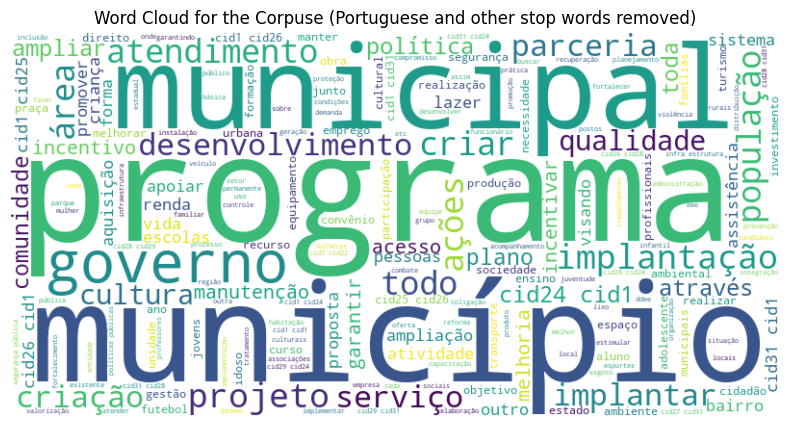

In [18]:
text_lower=' '.join([x.lower() for x in text.split()])
# Word Cloud para Reseñas Positivas
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop).generate(text_lower)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the Corpuse (Portuguese and other stop words removed)')
plt.show()

In [19]:
# These are the manually coded categories. The methodology involved using the section titles as a foundation, followed by standardization adjustments made by me.
df['section'].unique()

array(['Titulo', 'Educacion', 'Salud', 'Politica Social',
       'Infraestructura', 'Deporte y Cultura', 'Juventud', 'Produccion',
       'Servidor Publico', 'Introduccion', 'Vacio', 'Agricultura',
       'Infancia y Vejez', 'Urbana', 'Empleo e Ingresos', 'Deportes',
       'Cultura', 'Transporte', 'Ambiente', 'Asistencia Social', 'Trash',
       'General', 'Admin', 'Participacion', 'Cultura y Deporte',
       'Juventud, Genero y Vejez', 'Discapacidad',
       'Admin y Participacion', nan, 'Desarrollo Economico', 'Gestion',
       'Desarrollo', 'Politicas Sociales', 'Industria y Comercio',
       'Vivienda', 'Deporte', 'Social', 'Empleo', 'Seguridad', 'Turismo',
       'Transito', 'Agua', 'Urbano', 'Calles', 'Centro de Eventos',
       'Desarrollo Social', 'Rural', 'Vejez', 'Limpieza', 'Funerarios',
       'Luces', 'Saneamiento', 'Comunicacion',
       'Infraestructura y Servicios', 'Saneamiento y Ambiente',
       'Empleo e ingresos', 'Desastres', 'Other', 'Educacion y Deporte',
     

In [20]:
# Create a dictionary to map categories to their corresponding topic IDs
categories_to_topics = {
    # Topic 1: Titles
    'Titulo': 1, 'Tiu': 1,
    
    # Topic 2: Introduction/General
    'Introduccion': 0, 'General': 0,
    
    # Topic 3: Public Administration and Participation
    'Servidores Publicos': 3, 'Servidores publicos': 3, 'Admin': 3, 'Servidor Publico': 3,
    'Participacion': 3, 'Admin y Participacion': 3, 'Gestion': 3, 'Gobierno': 3, 'Finanzas': 3,
    
    # Topic 4: Education, Sports, and Social Policies
    'Educacion y Deportes': 4, 'Cultura y deporte': 4, 'Turismo, Cultura y Deportes': 4,
    'Politicas sociales': 4, 'Desarrollo social': 4, 'Gender': 4, 'Cultura y  Turismo': 4,
    'Politica social': 4, 'Deporte y Juventud': 4, 'Deporte y Turismo': 4, 
    'Educacion, Cultura y Deporta': 4, 'Cultura y Turismo': 4, 'Educacion y Cultura': 4,
    'Asistencia social': 4, 'Deporte, cultura, juventud y turismo': 4, 'Educacion': 4,
    'Deporte y Cultura': 4, 'Politica Social': 4, 'Juventud': 4, 'Infancia y Vejez': 4, 
    'Deportes': 4, 'Cultura': 4, 'Asistencia Social': 4, 'Cultura y Deporte': 4,
    'Juventud, Genero y Vejez': 4, 'Discapacidad': 4, 'Politicas Sociales': 4, 
    'Deporte': 4, 'Social': 4, 'Desarrollo Social': 4, 'Vejez': 4, 'Educacion y Deporte': 4,
    'Cultura, deporte y turismo': 4, 'Genero': 4, 'Turismo': 4,
    
    # Topic 5: Health
    'Salud': 5,
    
    # Topic 6: Transportation, Urban Development, and Infrastructure
    'Transporte': 6, 'Transito': 6, 'Urbano y vivienda': 6, 'Infraestructura y transporte': 6,
    'Desarrollo Urbano': 6, 'Infraestructura': 6, 'Urbana': 6, 'Vivienda': 6, 'Urbano': 6,
    'Agua': 6, 'Aguas': 6, 'Calles': 6, 'Limpieza': 6, 'Luces': 6, 'Saneamiento': 6,
    'Infraestructura y Servicios': 6, 'Saneamiento y Ambiente': 6, 'Desastres': 6,
    'Saneamietnto': 6, 'Limpieza y Ambiente': 6,
    
    # Topic 7: Environment, Agriculture, and Economic Development
    'Ambiente y Agricultura': 7, 'Agricultura': 7, 'Rural': 7, 'Ambiene y Agricultura': 7,
    'Agricultura y Ambiente': 7, 'Ambiente': 7, 'Desarrollo sustentable': 7, 'Produccion': 7,
    'Desarrollo Sustentable': 7, 'Desarrollo Economico y Sustentable': 7, 
    'Empleo e Ingresos': 7, 'Desarrollo Economico': 7, 'Desarrollo': 7, 
    'Industria y Comercio': 7, 'Empleo': 7, 'Empleo e ingresos': 7, 
    'Desarrollo Sostenible': 7, 'Economia Solidaria': 7, 'Empleo y Renta': 7,
    
    # Topic 8: Trash or Empty Categories
    'Trash': 2, 'nan': 2, 'Vacio': 2,
    
    # Topic 9: Security
    'Seguridad': 8,
    
    # Topic 10: Other
    'Centro de Eventos': 0, 'Funerarios': 0, 'Comunicacion': 0, 'Other': 0, 
    'Otros': 0, 'Religion': 0
}

# Map the 'section' column to the corresponding topic using the dictionary
df['top'] = df['section'].map(categories_to_topics).fillna(0).astype(int)  # Default to 0 ("Other") if no match is found


In [21]:
# Frequency of each topic in the set of manually classified manifestos.
df.groupby('top').count()['text']/len(df)*100

top
0    14.971740
1     2.850405
2     6.209084
3     8.303176
4    31.256862
5     9.494572
6    10.559915
7    13.902330
8     2.451917
Name: text, dtype: float64

In [22]:
print('Total:',sum(df.groupby('top').count()['text']/len(df)*100))

Total: 99.99999999999999


## Model Selection
In this section, I will explore and compare the performance of the following models:

1. Naive Bayes
2. K-Neighbors
3. Random Forest
4. SVC
5. LSTM
6. OpenAI

For the first four models, the preprocessing steps and pipelines are similar, ensuring a streamlined and consistent workflow. The LSTM and OpenAI API-based models require different preprocessing and implementation, which will be highlighted separately.

To ensure a fair comparison, I use the same training and test split across all models. This allows me to evaluate each model using identical metrics applied to the same test dataset, ensuring consistency and reliability in performance evaluation.

I use *f1_weighted* as the scoring metric because it accounts for both precision and recall, providing a balanced evaluation of model performance across all classes. The "weighted" aspect ensures that the metric reflects the contribution of each class proportionally to its size, making it suitable for datasets with class imbalances (as this one, see table above). This way, the evaluation remains fair and representative of the overall performance.

In [23]:
X = df['text'] #Features
y = df['top']  #Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train=y_train

In [24]:
all_predictions = []  # List to store predictions for each iteration

In [25]:
# I export the test set so I can use it for the classification performed with OpenAI
pd.DataFrame([X_test,y_test]).transpose().to_csv('test_data_for_openAI.csv')

In [26]:
# Define a basic tokenization function for text data
# This function splits a given text into individual words (tokens) based on spaces
def tokenize(text):
    return text.split()

# Define a tokenization function with stemming using the Snowball Stemmer
# This function splits the text into words and then applies the Snowball Stemmer to reduce each word to its root form
def tokenize_snowball(text):
    return [snowballStemmer.stem(word) for word in text.split()]

# These tokenization functions are designed to be incorporated into a grid search pipeline for hyperparameter tuning.

## Naive Bayes

In [27]:
start_time = time.time()

# Define a pipeline with a TF-IDF vectorizer and a Multinomial Naive Bayes classifier
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),  # TF-IDF feature extraction for text data
    ("clf", naive_bayes.MultinomialNB())  # Multinomial Naive Bayes classifier
])

# Define hyperparameter grid for grid search
params = [
    {
        "vect__ngram_range": [(1, 1), (1, 2)],  # Unigrams or unigrams + bigrams
        "vect__stop_words": [stop, None],  # Optionally include stopword removal
        "vect__tokenizer": [tokenize, tokenize_snowball],  # Test different tokenization strategies
        "clf__alpha": [0.01, 0.1, 0.5, 1.0, 3.0, 10.0]  # Regularization parameter for Naive Bayes
    }
]

# Perform a grid search to find the best combination of hyperparameters
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    scoring='f1_weighted',  # Optimize for weighted F1 score
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Display progress information
    n_jobs=4  # Use 4 parallel jobs for faster computation
)

# Fit the grid search to the training data
grid.fit(X_train, y_train)

# Retrieve the best model from the grid search
model = grid.best_estimator_

# Make predictions on the test set using the best model
predictions_NB = model.predict(X_test)

# Append predictions to a list for later analysis
all_predictions.append(predictions_NB)
end_time = time.time()
print(f"Classification process completed in {end_time - start_time:.2f} seconds.")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\guill\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification process completed in 471.06 seconds.


## K-neighbors

In [28]:
start_time = time.time()

# Define a pipeline with a TF-IDF vectorizer and a K-Nearest Neighbors classifier
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),  # TF-IDF feature extraction
    ("clf", KNeighborsClassifier())  # K-Nearest Neighbors classifier
])

# Define hyperparameter grid for grid search
params = [
    {
        "vect__ngram_range": [(1, 1), (1, 2)],  # Test unigrams or unigrams + bigrams
        "vect__stop_words": [stop, None],  # Include or exclude stopwords
        "vect__tokenizer": [tokenize, tokenize_snowball],  # Test different tokenization methods
        "clf__p": [1, 2],  # Distance metric: 1 (Manhattan) or 2 (Euclidean)
        "clf__n_neighbors": [1, 2, 5, 10, 15, 20]  # Number of neighbors to consider
    }
]

# Perform grid search to optimize hyperparameters for the KNN model
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    scoring='f1_weighted',  # Optimize for weighted F1 score
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Display progress during grid search
    n_jobs=4  # Use 4 parallel jobs for faster computation
)

# Fit the grid search to the training data
grid.fit(X_train, y_train)

# Retrieve the best model from the grid search
model = grid.best_estimator_

# Make predictions on the test set using the best model
predictions_KN = model.predict(X_test)

# Append the predictions for future evaluation
all_predictions.append(predictions_KN)
end_time = time.time()
print(f"Classification process completed in {end_time - start_time:.2f} seconds.")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\guill\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\guill\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-don', 'aarã', 'abad', 'abadi', 'abadiân', 'abaet', 'abai', 'abaix', 'abar', 'abati', 'abaír', 'abelard', 'abelarzinh', 'abobrinh', 'abra', 'abrahã', 'abrant', 'abraã', 'abreulând', 'abrã', 'abíli', 'acac', 'academ', 'acaiac', 'acajutib', 'acar', 'acarap', 'accaci', 'acegu', 'acelin', 'achill', 'acim', 'acinesi', 'acion', 'acopi', 'acord', 'acrelând', 'acreún', 'acáci', 'acássi', 'ada', 'adailm', 'adailt', 'adailz', 'adalbert', 'adalcin', 'adalgis', 'adalt', 'adam', 'adamantin', 'adari', 'adauri', 'adaut', 'adecim', 'adejuni', 'adelaid', 'adelbart', 'adelci', 'adeli', 'adelin', 'adelm', 'adelminh', '

Classification process completed in 1202.33 seconds.


## Support Vector Classifier

In [29]:
start_time = time.time()

# Define a pipeline with a TF-IDF vectorizer and a Support Vector Classifier (SVC)
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),  # TF-IDF feature extraction
    ("clf", SVC())  # Support Vector Classifier
])

# Define hyperparameter grid for grid search
params = [
    {
        "vect__ngram_range": [(1, 1), (1, 2)],  # Test unigrams or unigrams + bigrams
        "vect__stop_words": [stop, None],  # Include or exclude stopwords
        "vect__tokenizer": [tokenize, tokenize_snowball],  # Test different tokenization methods
        "clf__probability": [True]  # Enable probability estimates for SVC
    }
]

# Perform grid search to optimize hyperparameters for the SVC model
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    scoring='f1_weighted',  # Optimize for weighted F1 score
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Display progress during grid search
    n_jobs=4  # Use 4 parallel jobs for faster computation
)

# Fit the grid search to the training data
grid.fit(X_train, y_train)

# Retrieve the best model from the grid search
model = grid.best_estimator_

# Make predictions on the test set using the best model
predictions_SVC = model.predict(X_test)

# Append the predictions for future evaluation
all_predictions.append(predictions_SVC)
end_time = time.time()
print(f"Classification process completed in {end_time - start_time:.2f} seconds.")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\guill\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification process completed in 4186.56 seconds.


## Random Forest

In [30]:
start_time = time.time()

# Define the pipeline with a Random Forest Classifier
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", RandomForestClassifier(random_state=42))
])

# Define the hyperparameters for grid search
params = [{
    "vect__ngram_range": [(1,1), (1,2)],
    "vect__stop_words": [stop, None],
    "vect__tokenizer": [tokenize, tokenize_snowball],
    "clf__n_estimators": [50, 100],  # Number of trees in the forest
    "clf__max_depth": [10, 20, 30],  # Maximum depth of the tree
    "clf__min_samples_split": [2, 5, 10],  # Minimum number of samples required to split a node
    "clf__min_samples_leaf": [1, 2, 4]  # Minimum number of samples required at a leaf node
}]

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='f1_weighted', cv=3, verbose=1, n_jobs=3)

# Fit the model
grid.fit(X_train, y_train)

# Get the best model and make predictions
model = grid.best_estimator_
predictions_RF = model.predict(X_test)
all_predictions.append(predictions_RF)
end_time = time.time()
print(f"Classification process completed in {end_time - start_time:.2f} seconds.")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


C:\Users\guill\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification process completed in 2531.87 seconds.


## LSTM

In [31]:
# Function to create the LSTM model
def create_lstm_model(max_words=1000, maxlen=200):
    """
    Creates an LSTM model for text classification.

    Args:
        max_words (int): The maximum number of words to consider in the vocabulary.
        maxlen (int): The fixed length for padding/truncating input sequences.

    Returns:
        model: A compiled LSTM model.
    """
    model = Sequential()
    
    # Embedding layer to convert word indices into dense vector representations
    model.add(Embedding(max_words, 128, input_length=maxlen))
    
    # LSTM layer with 64 units to capture sequential dependencies in text
    model.add(LSTM(64))
    
    # Dense output layer with the number of classes and softmax activation for multiclass classification
    model.add(Dense(len(encoder.classes_), activation='softmax'))
    
    # Compile the model with Adam optimizer and sparse categorical cross-entropy loss
    model.compile(
        optimizer='adam',  # Adaptive learning rate optimization
        loss='sparse_categorical_crossentropy',  # Suitable for integer labels
        metrics=['accuracy']  # Track accuracy during training
    )
    return model

# Tokenizer and padding function for text preprocessing
def preprocess_texts(texts, max_words, maxlen=200):
    """
    Tokenizes and pads text data for LSTM input.

    Args:
        texts (list): List of text strings to preprocess.
        max_words (int): The maximum size of the vocabulary.
        maxlen (int): The fixed length for padding/truncating input sequences.

    Returns:
        data (ndarray): Padded sequences ready for model input.
    """
    # Initialize the tokenizer with the maximum number of words in the vocabulary
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)  # Fit tokenizer on the text data
    
    # Convert texts to sequences of word indices
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences to ensure uniform input length
    data = pad_sequences(sequences, maxlen=maxlen)
    return data

In [32]:
start_time = time.time()
# Label encoding for the target variable
encoder = LabelEncoder()
train_labels = encoder.fit_transform(y_train)
test_labels = encoder.transform(y_test)

# Preprocess texts for four models
maxlen = 200  # Sequence length
max_words_options = [1000, 1500, 2000, 2500]  # Different vocabulary sizes for comparison

# Train and evaluate each model
for max_words in max_words_options:
    # Preprocess texts for this model
    train_data = preprocess_texts(X_train, max_words, maxlen)
    test_data = preprocess_texts(X_test, max_words, maxlen)
    
    # Create and train the LSTM model
    model = create_lstm_model(max_words=max_words, maxlen=maxlen)
    model.fit(train_data, train_labels, epochs=7, batch_size=64)
    
    # Make predictions on the test set
    predictions = model.predict(test_data)
    predictions = np.argmax(predictions, axis=1)
    
    # Save the predictions for this model
    all_predictions.append(list(predictions))
end_time = time.time()
print(f"Classification process completed in {end_time - start_time:.2f} seconds.")

Epoch 1/7
289/289 [==============================] - 87s 295ms/step - loss: 1.6341 - accuracy: 0.4318
Epoch 2/7
289/289 [==============================] - 85s 295ms/step - loss: 1.2295 - accuracy: 0.5943
Epoch 3/7
289/289 [==============================] - 89s 309ms/step - loss: 1.1403 - accuracy: 0.6190
Epoch 4/7
289/289 [==============================] - 87s 300ms/step - loss: 1.0978 - accuracy: 0.6326
Epoch 5/7
289/289 [==============================] - 90s 312ms/step - loss: 1.0662 - accuracy: 0.6400
Epoch 6/7
289/289 [==============================] - 89s 308ms/step - loss: 1.0380 - accuracy: 0.6462
Epoch 7/7
193/193 [==============================] - 9s 44ms/step
Epoch 1/7
289/289 [==============================] - 88s 297ms/step - loss: 1.6363 - accuracy: 0.4326
Epoch 2/7
289/289 [==============================] - 86s 297ms/step - loss: 1.1829 - accuracy: 0.6161
Epoch 3/7
289/289 [==============================] - 88s 305ms/step - loss: 1.0682 - accuracy: 0.6528
Epoch 4/7
289/28

In [33]:
predictions_df=pd.DataFrame(all_predictions)
predictions_df.to_csv('predictions.csv') # I will use these predictions when doing the analysis.